# 계란 보관 일 수 예측 모델 (Image only)

이 노트북은 인공지능 데이터 구축 사업의 일환인 `계란 데이터 구축 과제` 의 결과물 중 하나인 `계란 보관 데이터` 의 활용 예시를 보여줍니다.
본 노트북은 보관 일 수 데이터로부터 학습 데이터를 구축하는 데이터 로더 모듈과 모델 학습 코드를 포함하며 마지막으로 학습된 모델을 사용한 추론 예시를 보여줍니다.



## 데이터 셋

제공되는 계란 보관일 수 예측 데이터 셋은 다음과 같은 구조를 갖습니다.

```
/data
|_1일/
|   |_세척/
|   |   |_ 기형/
|   |   |   |_1234.jpg
|   |   |   |_1234.xml
|   |   |- 크랙/
|   |   |- 혈반/
|   |   |- 정상/
|   |   |- 이물질/
|   |   |- 잠재크랙/
|   |_비세척/
|        |_ ...
|_2일/
...
```

해당 데이터로부터 학습 가능한 형태의 데이터 셋을 새로 구축하고 이를 활용하여 모델을 학습합니다.


In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 셋 구축

DATA_PATH = '/ssd_ext/ssd500/yejyang/eggData/신선도'
DATA_CSV = './freshness_data.csv'
if not os.path.isfile(DATA_CSV):

    # load 'image' list & 'label list'
    img_list, label_list, CLASS = [], [], []
    for (path, dir_name, files) in os.walk(DATA_PATH):
        for file in files:

            # if there is 'image' and 'xml'
            if (os.path.splitext(file)[1] == '.jpg') and (os.path.isfile(path + '/' + os.path.splitext(file)[0]+'.xml')):
                img_path = path + '/' + file
                img_list.append(img_path)
                label_list.append(path + '/' + os.path.splitext(file)[0]+'.xml')
                paths = img_path.split(os.path.sep)
                CLASS.append(paths[-3] + '/' + paths[-2])

    # parsing label
    DAY, WASH = [], []
    for label in label_list:
        xml_content = ET.parse(label)
        root = xml_content.getroot()
        # DAY
        DAY.append(int(root.findtext("days")))
        # WASH (0/1)
        WASH.append(int(root.findtext("wash"))-1)


    raw_data = {'IMG': img_list, 'DAY': DAY, 'WASH': WASH, 'CLASS': CLASS}
    data = pd.DataFrame(raw_data)
    data.to_csv(DATA_CSV)

else:
    data = pd.read_csv(DATA_CSV)

In [3]:
# 데이터 셋 로드 (Train : Validation : Test = 8 : 1 : 1)
random_state = 99
train_df, test_df = train_test_split(data, test_size=0.1, stratify=data['DAY'].values, random_state=random_state)
train_df, val_df = train_test_split(train_df, test_size=0.11, random_state=random_state)

print(f"Dataset is split into Train : Validation : Test = {len(train_df)} : {len(val_df)} : {len(test_df)}")

Dataset is split into Train : Validation : Test = 830832 : 102688 : 103725


## 모델 구축

본 노트북에서는 계란 상태 클래스 없이 이미지와 세척 여부만으로 보관 일 수를 예측하는 모델을 학습한다.
이를 위해 데이터를 먼저 모델에 맞는 형태로 전처리를 수행하고 모델을 학습한다.

In [4]:
def input_loader(sample, img_size=(128, 128)):

    ####################################
    # load image
    ####################################
    img = tf.io.read_file(sample['IMG'])
    if tf.strings.split(sample['IMG'])[-1] == b"jpg":
        img = tf.image.decode_jpeg(img, 3) 
    else: 
        img = tf.image.decode_png(img, 3)
    img = tf.image.resize(img, img_size)
    
    return {"IMG": img}


def create_dataset(dataframe, batch_size=256, is_train=True):

    columns = ["IMG", "DAY"]
    df = dataframe[columns].copy()
    label = df.pop("DAY")
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), label))
    dataset = dataset.shuffle(buffer_size=len(dataframe))

    if is_train:
        dataset = dataset.shuffle(len(dataframe))

    dataset = dataset.map(lambda x, y: (input_loader(x), y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [5]:
batch_size = 512
dataset_tr = create_dataset(train_df, batch_size=batch_size)
dataset_val = create_dataset(val_df, batch_size=batch_size)
dataset_test = create_dataset(test_df, batch_size=batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
# Build multi-modal model

def create_model(is_train=True):

    # image input
    img = keras.Input(shape=(128, 128, 3), name="IMG")
    resnet = keras.applications.ResNet50V2(include_top=False, weights="imagenet", pooling="avg", input_shape=(128, 128, 3))
    resnet.trainable = True
    
    preprocessed_img = keras.applications.resnet_v2.preprocess_input(img)
    img_embedding = resnet(preprocessed_img)
    out = keras.layers.Dense(32, kernel_initializer="normal", activation="relu")(img_embedding)
    out = keras.layers.Dense(256, kernel_initializer="normal", activation="relu")(out)
    out = keras.layers.Dense(512, kernel_initializer="normal", activation="relu")(out)
    out = keras.layers.Dense(512, kernel_initializer="normal", activation="relu")(out)
    out = keras.layers.Dense(512, kernel_initializer="normal", activation="relu")(out)
    out = keras.layers.Dense(64, kernel_initializer="normal", activation="relu")(out)
    out = keras.layers.Dense(1, kernel_initializer="normal", activation="relu")(out)

    return keras.Model(img, out)

In [7]:
# if you train the model with multiple GPUs
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    model = create_model()
    model.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.mse, keras.metrics.mean_absolute_error])

# Train model!
epochs = 20
cb_earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
cb_bestSave = tf.keras.callbacks.ModelCheckpoint('./freshness_model_best.hdf5', save_best_only=True, monitor="val_loss", mode="min")
cb_lr_scheduling = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode="min")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IMG (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 256)               8448  

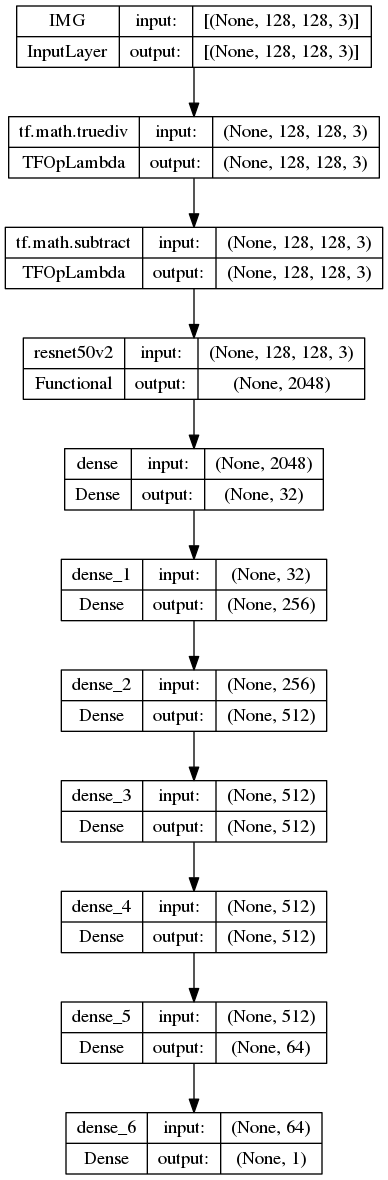

In [9]:
from IPython.display import display, Image
from keras.utils import model_to_dot, plot_model

plot_model(model, to_file='model.png', show_shapes=True)
display(Image('./model.png'))

In [10]:
train_log = model.fit(dataset_tr, epochs=epochs, validation_data=dataset_val, callbacks=[cb_earlyStopping, 
                                                                                         cb_bestSave, 
                                                                                         cb_lr_scheduling])

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
1623/1623 [==============================] - 1000s 567ms/step - loss: 41.1284 - mean_squared_error: 41.1284 - mean_absolute_error: 4.0726 - val_loss: 344.4516 - val_mean_squared_error: 344.4516 - val_mean_absolute_error: 14.4904 - lr: 0.0010
Epoch 2/20
1623/1623 [==============================] - 918s 563ms/step - loss: 20.3679 - mean_squared_error: 20.3679 - mean_absolute_error: 2.7899 - val_loss: 78.0296 - val_mean_squared_error: 78.0296 - val_mean_absolute_error: 5.8635 - lr: 0.0010
Epoch 3/20
1623/1623 [==============================] - 915s 561ms/step - loss: 16.4964 - mean_squared_error: 16.4964 - mean_absolute_error: 2.4535 - val_loss: 150.3736 - val_mean_squared_error: 150.3736 - val_mean_absolute_error: 7.4625 - lr: 0.0010
Epoch 4/20
1623/1623 [==============================] - 914s 560ms/step -

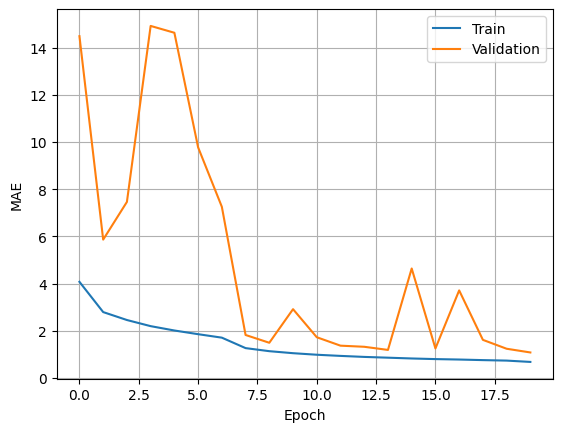

In [11]:
# Train log plot
import matplotlib.pyplot as plt

plt.plot(train_log.history['mean_absolute_error'])
plt.plot(train_log.history['val_mean_absolute_error'])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

In [12]:
print(train_log.history['mean_absolute_error'])
print(train_log.history['val_mean_absolute_error'])

[4.072620391845703, 2.7899203300476074, 2.4534828662872314, 2.1935067176818848, 2.009023427963257, 1.8524367809295654, 1.7053625583648682, 1.261825442314148, 1.131840705871582, 1.0465370416641235, 0.9808326363563538, 0.9316641092300415, 0.8886799812316895, 0.855830192565918, 0.8224362730979919, 0.7961689233779907, 0.7774664163589478, 0.7527755498886108, 0.7323737144470215, 0.6762226223945618]
[14.49044418334961, 5.86347770690918, 7.462454319000244, 14.926074981689453, 14.636039733886719, 9.776668548583984, 7.255354881286621, 1.818734884262085, 1.4887343645095825, 2.9134154319763184, 1.723251223564148, 1.3654557466506958, 1.318433165550232, 1.1853278875350952, 4.638225555419922, 1.2475767135620117, 3.7091503143310547, 1.611853837966919, 1.2349016666412354, 1.0774837732315063]


In [13]:
import gc
gc.collect()
tf.keras.backend.clear_session()
# Test trained model (best model)
loaded_model = tf.keras.models.load_model('freshness_model_best.hdf5')
acc = loaded_model.evaluate(dataset_test, batch_size=128)

203/203 [==============================] - 50s 225ms/step - loss: 7.4485 - mean_squared_error: 7.4485 - mean_absolute_error: 1.0738
